In [20]:
from scipy.io import savemat
import scipy.io     # used to load .mat data

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import seaborn as sns

from models import TandemNet, MLP ,cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, MLP_sigmoid
from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem, cVAE_GSNN1
from utils import evaluate_tandem_minmax_accuracy, evaluate_forward_minmax_dataset, evaluate_forward_minmax, evaluate_vae_GSNN_minmax_inverse, evaluate_gan_minmax_inverse, evaluate_inn_minmax_inverse

from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred, plt_abs_err, plt_hist_struc, plot_struc_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score
import seaborn as sns

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('forward_model')




In [21]:
# define some necessary functions for the predictions

def struc_check(structure):
    if np.sum(abs(structure)-structure)>0:  # if get negative parameters, then wrong structure
        return 0
    else:
        struc = np.reshape(structure, (-1, 4))
        N = np.shape(struc)[0]
        #print(struc)
        for i in range(N):
            if (struc[i,1]+struc[i,3]>=struc[i,2]):  # if gap+diameter >= period, then wrong structure
                return 0
        
        return 1

def struc_check_all(structure):

    struc = np.reshape(structure, (-1, 4))
    N = np.shape(struc)[0]

    for i in range(N):
        if (np.sum(abs(struc[i,:])-struc[i,:])==0)&(struc[i,1]+struc[i,3]<struc[i,2]):
            return 1 # once a structrue satisfy the requirement then it is called success
    return 0


def struc_remove_1(param_pred, show=0):
    M = np.shape(param_pred)[0]
    B = []
    print(M)
    for i in range(M):
        if struc_check_all(param_pred[i,:])==0:
            B.append(i)
            if show==1:
                print(i)
    
    return B

def struc_remove_2(param_pred):
    # remove the structure that is not inside the parameter range space. 
    M = np.shape(param_pred)[0]
    B = []
    for i in range(M):
        if (param_pred[i,3]>=160)|(param_pred[i,3]<=80)|(param_pred[i,0]>=200)|(param_pred[i,0]<=30)|(param_pred[i,1]>=320)|(param_pred[i,1]<=160)|(param_pred[i,2]>=700)|(param_pred[i,2]<=30):
            B.append(i)
            #print(i)
    
    return B

    
def plt_hist_struc1(param, labels):
    xlim = [[0, 210], [150, 330], [280, 720], [75, 165]]
    plt.figure(dpi=300, figsize = [20, 3])
    plt.subplot(1, 4,1)
    plt.hist(param[:,0], bins=20, histtype='step', label=labels)
    plt.title('Height histogram')
    plt.xlabel('Height/(nm)')
    plt.ylabel('Count')
    plt.xlim(xlim[0])
    plt.legend()
    
    plt.subplot(1, 4,2)
    plt.hist(param[:,1], bins=20, histtype='step', label=labels)
    plt.title('Gap histogram')
    plt.xlabel('Gap/(nm)')
    plt.xlim(xlim[1])
    
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.hist(param[:,2], bins=20, histtype='step', label=labels)
    plt.title('Period histogram')
    plt.xlabel('Period/(nm)')
    plt.ylabel('Count')
    plt.xlim(xlim[2])
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.hist(param[:,3], bins=20, histtype='step', label=labels)
    plt.title('Diameter histogram')
    plt.xlabel('Diamater/(nm)')
    plt.ylabel('Count')
    plt.legend()
    plt.xlim(xlim[3])
    plt.show()



In [22]:
# THis is used for color conversion

M_RGB_TO_XYZ = np.array([
    [0.5767309, 0.1855540  ,0.1881852],
    [0.2973769 , 0.6273491  ,0.0752741],
    [0.0270343,  0.0706872  ,0.9911085]])

M_sRGB_TO_XYZ = np.array([
    [ 0.4124564 , 0.3575761  ,0.1804375],
    [0.2126729 , 0.7151522  ,0.0721750],
    [0.0193339 , 0.1191920 , 0.9503041]])

M_XYZ_TO_sRGB = np.linalg.inv(M_sRGB_TO_XYZ)    
M_XYZ_TO_RGB = np.linalg.inv(M_RGB_TO_XYZ)   


def XYZ_to_xyY(xyz_a):
    len_a = len(xyz_a)
    xyY_a = np.zeros([len_a, 3])
    temp_a = np.sum(xyz_a, axis=1)
    for i in range(len_a):
        if temp_a[i]==0.0:
            xyY_a[i,0] = 0.313
            xyY_a[i,1] = 0.329
            xyY_a[i,2] = 0
            continue
        xyY_a[i,0] = xyz_a[i,0]/temp_a[i]
        xyY_a[i,1] = xyz_a[i,1]/temp_a[i]
        xyY_a[i,2] = xyz_a[i,1]

    return xyY_a

def xyY_to_XYZ(xyY):
    # http://www.brucelindbloom.com/index.html?Eqn_xyY_to_XYZ.html
    temp = len(xyY)

    XYZ = np.zeros([temp, 3])
    for i in range(temp):
        if xyY[i,1] ==0:
            continue
        XYZ[i,0] = xyY[i,0]*xyY[i,2]/xyY[i,1]
        XYZ[i,1] = xyY[i,2]
        XYZ[i,2] = (1-xyY[i,0]-xyY[i,1])*xyY[i,2]/xyY[i,1]
    
    return XYZ


def xyY_to_RGB(xyY):

    return np.dot(xyY_to_XYZ(xyY), np.transpose(M_XYZ_TO_RGB))

def RGB_to_xyY(RGB):

    return XYZ_to_xyY(np.dot(RGB, np.transpose(M_RGB_TO_XYZ)))

In [23]:
# import the color packages

import colour
import matplotlib as mpl
from colour.plotting import plot_chromaticity_diagram_CIE1931, ColourSwatch, plot_multi_colour_swatches, plot_sds_in_chromaticity_diagram_CIE1931
from colour.plotting.models import plot_RGB_colourspaces_in_chromaticity_diagram
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution


# Compare the struture distribution

In [24]:
# load files 

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams.update({'font.size': 15})

T= 1338

filepath_tandem = "./data_predicted/param_tandem_pred_all_xyY.mat"
temp = scipy.io.loadmat(filepath_tandem)
xyY_original = temp['CIE_x']
xyY_tandem = temp['xyY_pred']
print(xyY_original[T])
param_tandem = temp['param_pred']
param_pred_tandem = np.reshape(temp['param_pred'][T,:],(1,4))
param_pred_tandem = np.repeat(param_pred_tandem, 1000, axis=0)

filepath_tandem = "./data_predicted/param_vae_pred_1338_xyY.mat"
temp = scipy.io.loadmat(filepath_tandem)
xyY_vae = temp['xyY_pred']
param_pred_vae = temp['param_pred']
B_vae = struc_remove_1(param_pred_vae, show=0)
xyY_pred_vae =  np.delete(xyY_vae, B_vae, 0)
param_pred_vae =  np.delete(param_pred_vae, B_vae, 0)

filepath_tandem = "./data_predicted/param_gan_pred_1338_xyY.mat"
temp = scipy.io.loadmat(filepath_tandem)
xyY_gan = temp['xyY_pred']
param_pred_gan = temp['param_pred']
B_gan = struc_remove_1(param_pred_gan, show=0)
xyY_pred_gan =  np.delete(xyY_gan, B_gan, 0)
param_pred_gan =  np.delete(param_pred_gan, B_gan, 0)

RGB_pred_tandem = xyY_to_RGB(xyY_tandem)
RGB_pred_vae = xyY_to_RGB(xyY_pred_vae)
RGB_pred_gan = xyY_to_RGB(xyY_pred_gan)
RGB_original = xyY_to_RGB(xyY_original)


[ 0.29166867  0.57114028  0.47202545]
1000
1000


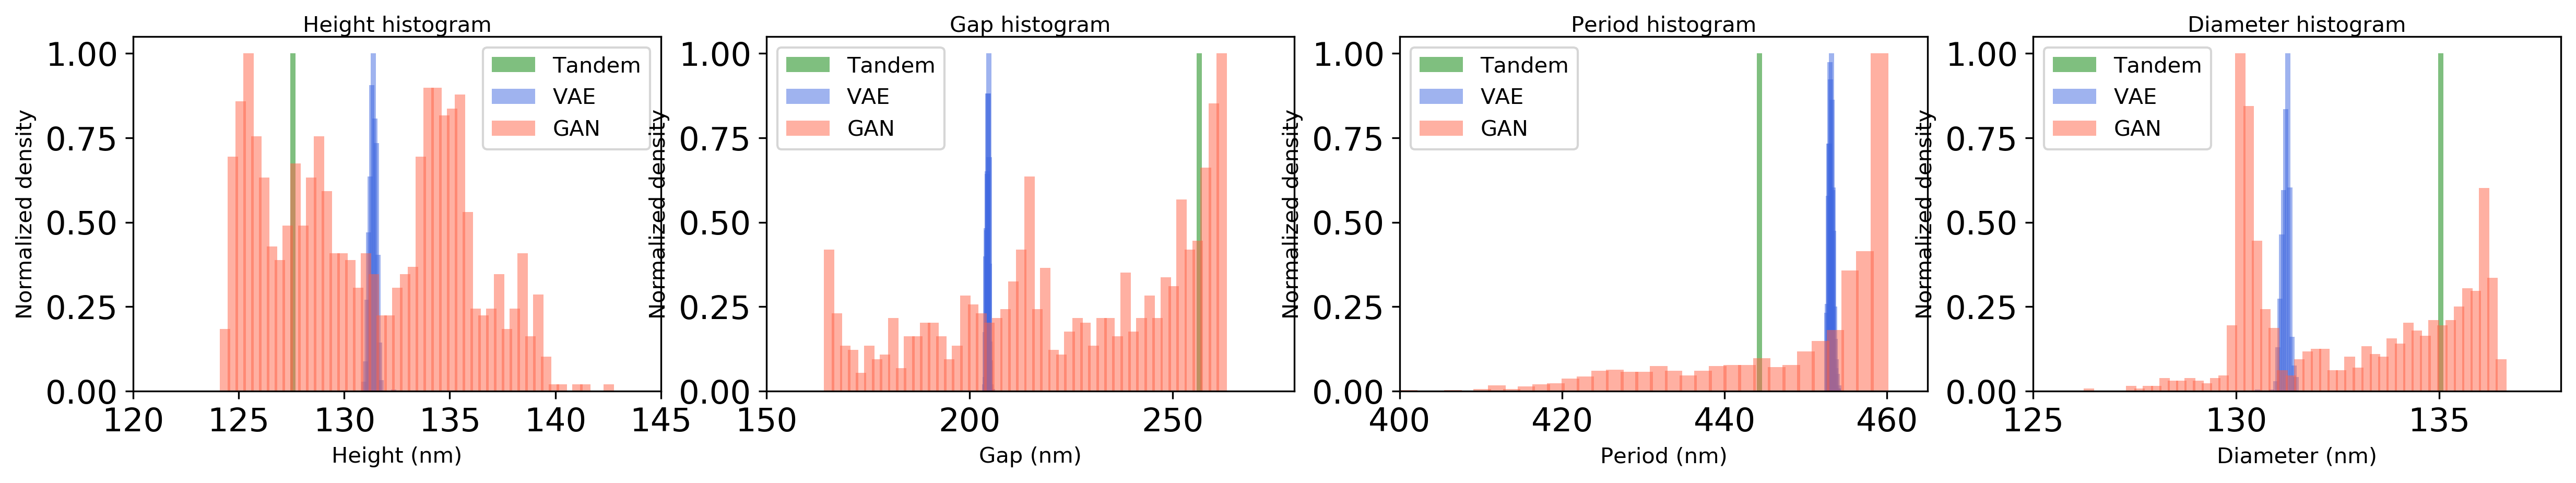

In [25]:
param_tandem = param_pred_tandem
param_vae = param_pred_vae
param_gan = param_pred_gan

xlim = [[120, 145], [150, 280], [400, 465], [125, 138]] # For green color, 1338



titles = ['Height histogram', 'Gap histogram', 'Period histogram', 'Diameter histogram']
xlabels = ['Height (nm)', 'Gap (nm)', 'Period (nm)', 'Diameter (nm)']
plt.figure(figsize = [20, 3], dpi=300)
for i in range(4):
    plt.subplot(1, 4,i+1)
    NN = 50
    h_t = np.histogram(param_tandem[:,i], bins=20, density=True)
    h_v = np.histogram(param_vae[:,i], bins=20, density=True)
    h_g = np.histogram(param_gan[:,i], bins=NN, density=True)

    d_t, b_t = np.insert(h_t[0], 0, 0), h_t[1]
    d_t = d_t/max(d_t)
    d_t, b_t = np.insert(d_t, 21, 0), np.insert(b_t, 21, xlim[i][1])
    d_v, b_v = np.insert(h_v[0], 0, 0), h_v[1]
    d_v = d_v/max(d_v)
    d_v, b_v = np.insert(d_v, 21, 0), np.insert(b_v, 21, xlim[i][1])
    d_g, b_g = np.insert(h_g[0], 0, 0), h_g[1]
    d_g = d_g/max(d_g)
    d_g, b_g = np.insert(d_g, NN+1, 0), np.insert(b_g, NN+1, xlim[i][1])
    # if i==2:
    #     print(b_g)

    # plt.step(b_t, d_t,  linewidth=1, c='green', label='Tandem')
    # plt.step(b_v, d_v,  linewidth=1, c='b', label='VAE')
    # plt.step(b_g, d_g,  linewidth=0.5, c='r', label='GAN')

    plt.bar(b_t, d_t, (xlim[i][1]-xlim[i][0])/100, fc='green', alpha=0.5, label='Tandem')
    plt.bar(b_v, d_v, (xlim[i][1]-xlim[i][0])/100, fc='royalblue', alpha = 0.5, label='VAE')
    if i==2:
        plt.bar(b_g, d_g, (xlim[i][1]-xlim[i][0])/30, fc='tomato', alpha = 0.5, label='GAN')
    else:
        plt.bar(b_g, d_g, (xlim[i][1]-xlim[i][0])/NN, fc='tomato', alpha = 0.5, label='GAN')


    plt.title(titles[i])
    plt.xlabel(xlabels[i])
    plt.ylabel('Normalized density')
    plt.xlim(xlim[i])
    plt.ylim([0,1.05])
    plt.legend()



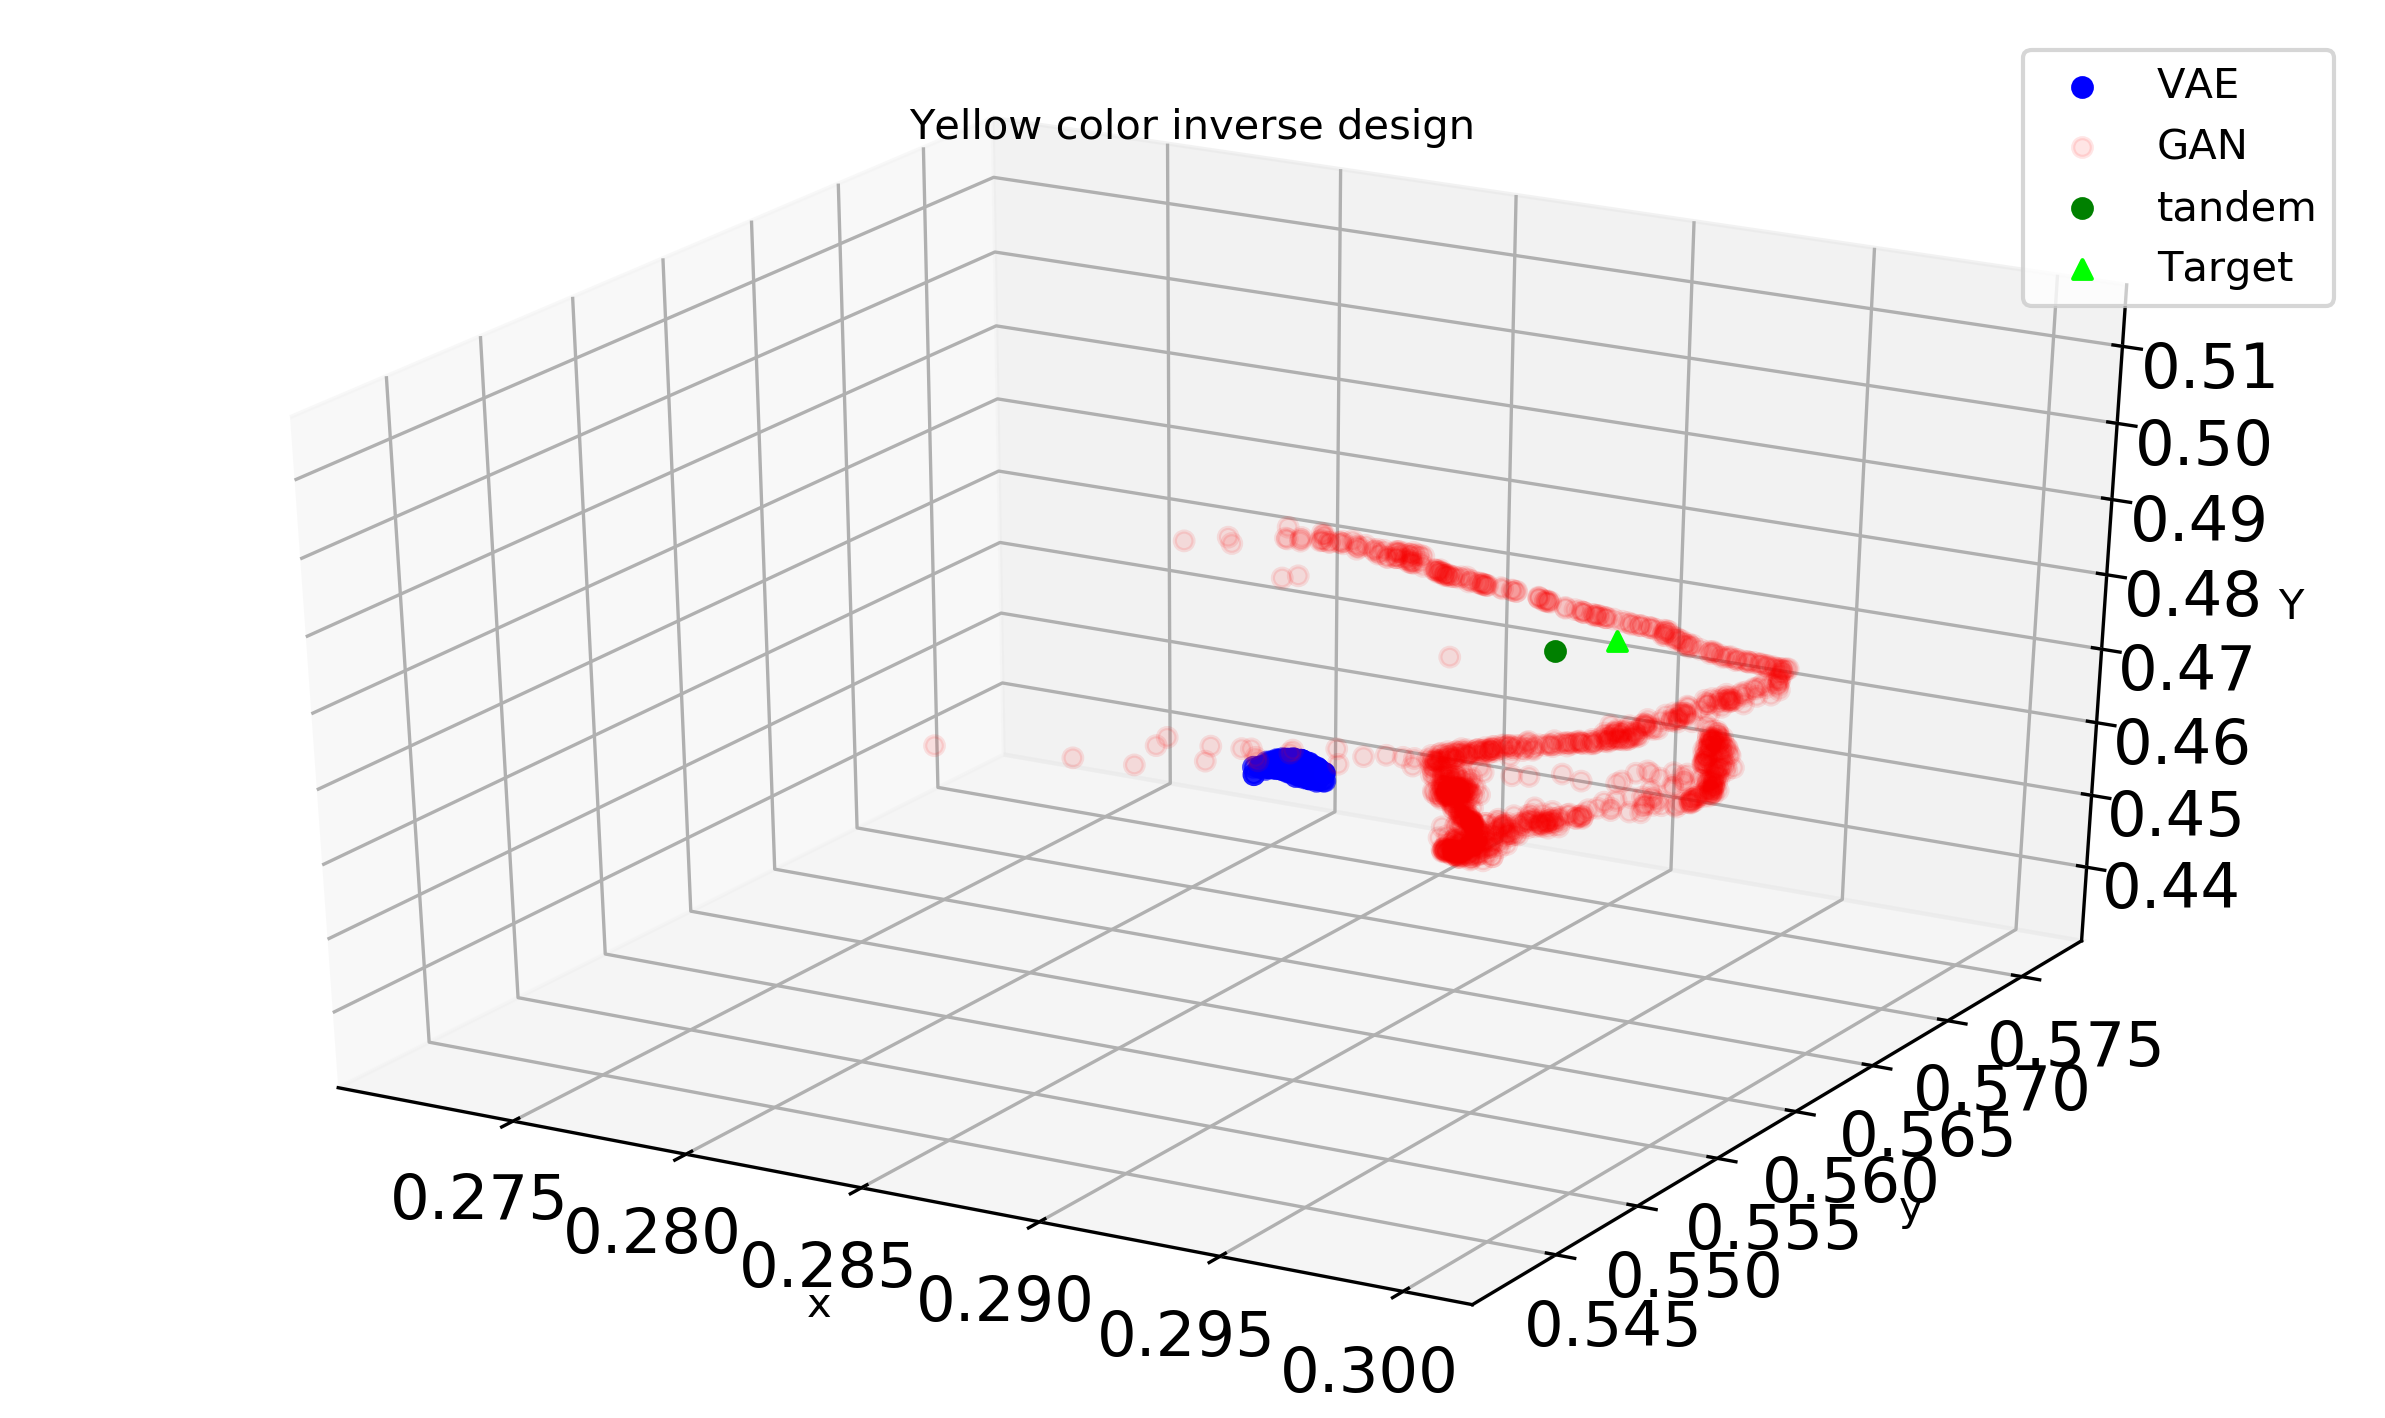

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10,6)


ax.scatter(xyY_pred_vae[:,0], xyY_pred_vae[:,1], xyY_pred_vae[:,2],  c='b', marker='o',label='VAE')
ax.scatter(xyY_pred_gan[:,0], xyY_pred_gan[:,1], xyY_pred_gan[:,2],  c='red', alpha=0.1, marker='o',label='GAN')
ax.scatter(xyY_tandem[T,0],xyY_tandem[T,1],xyY_tandem[T,2], c='g', marker='o',label='tandem')
ax.scatter(xyY_original[T,0],xyY_original[T,1],xyY_original[T,2], c='lime', marker='^',label='Target')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
ax.set_title('Yellow color inverse design')
plt.legend(loc='best')
plt.show()



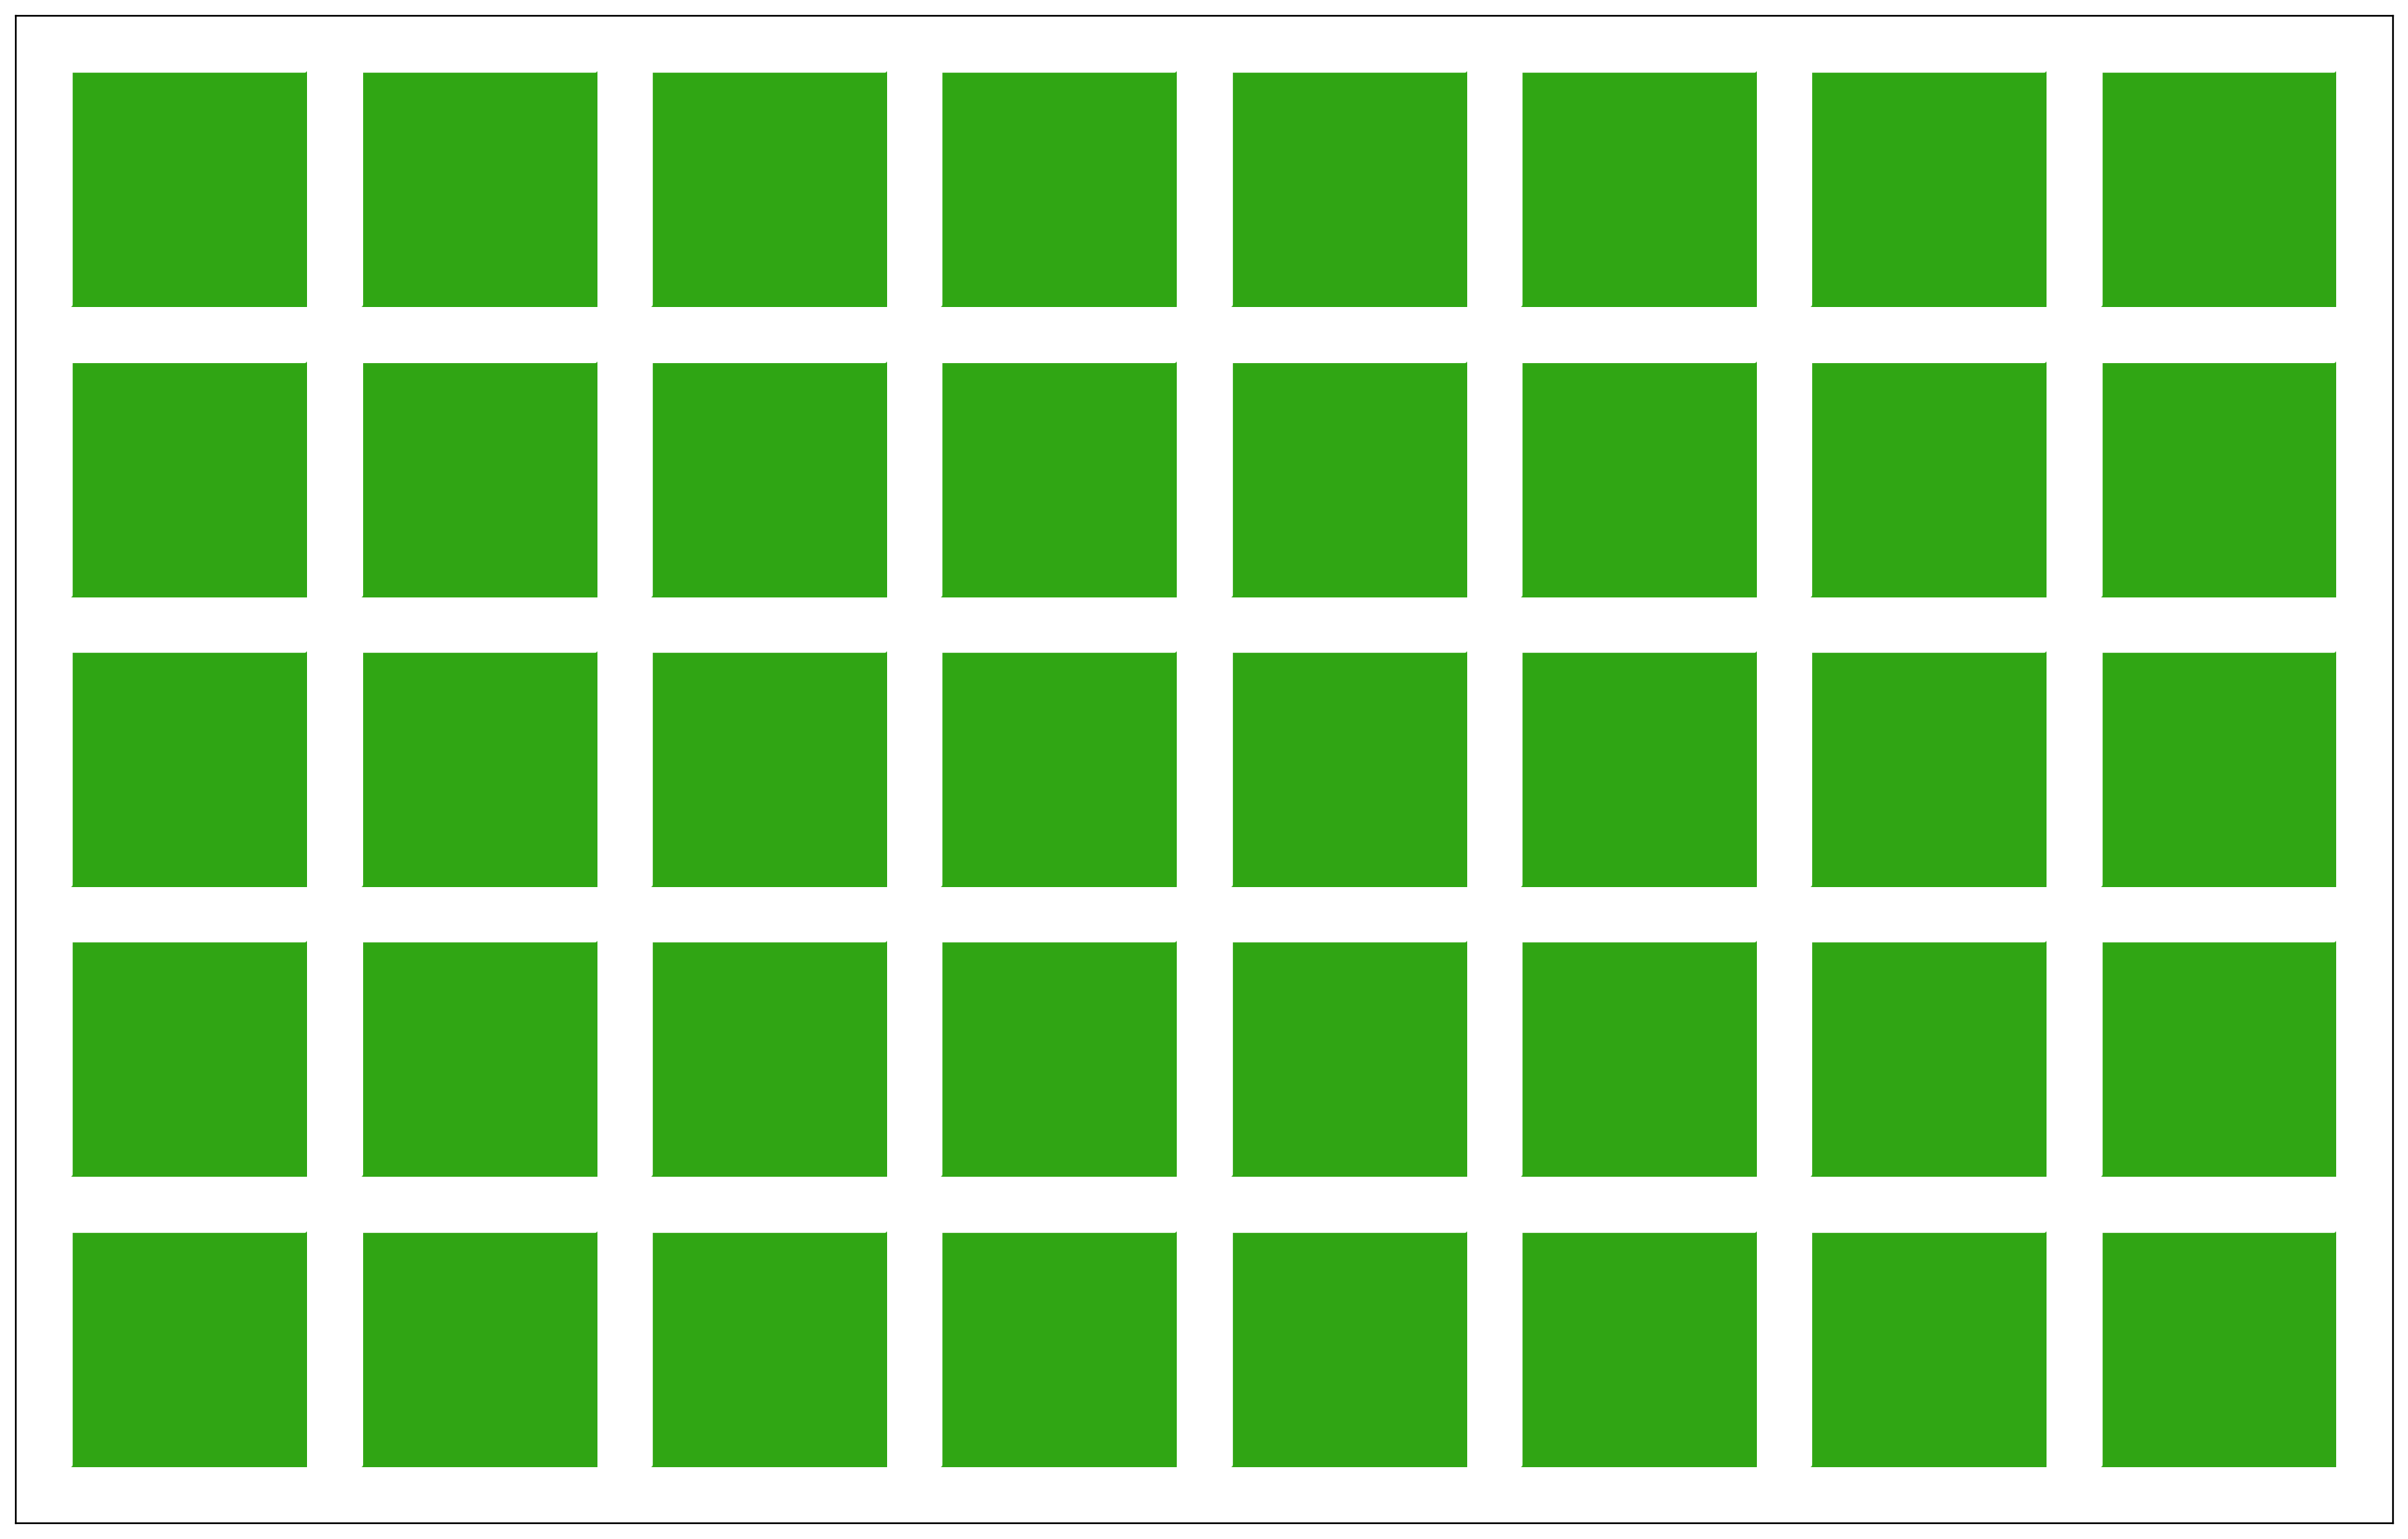

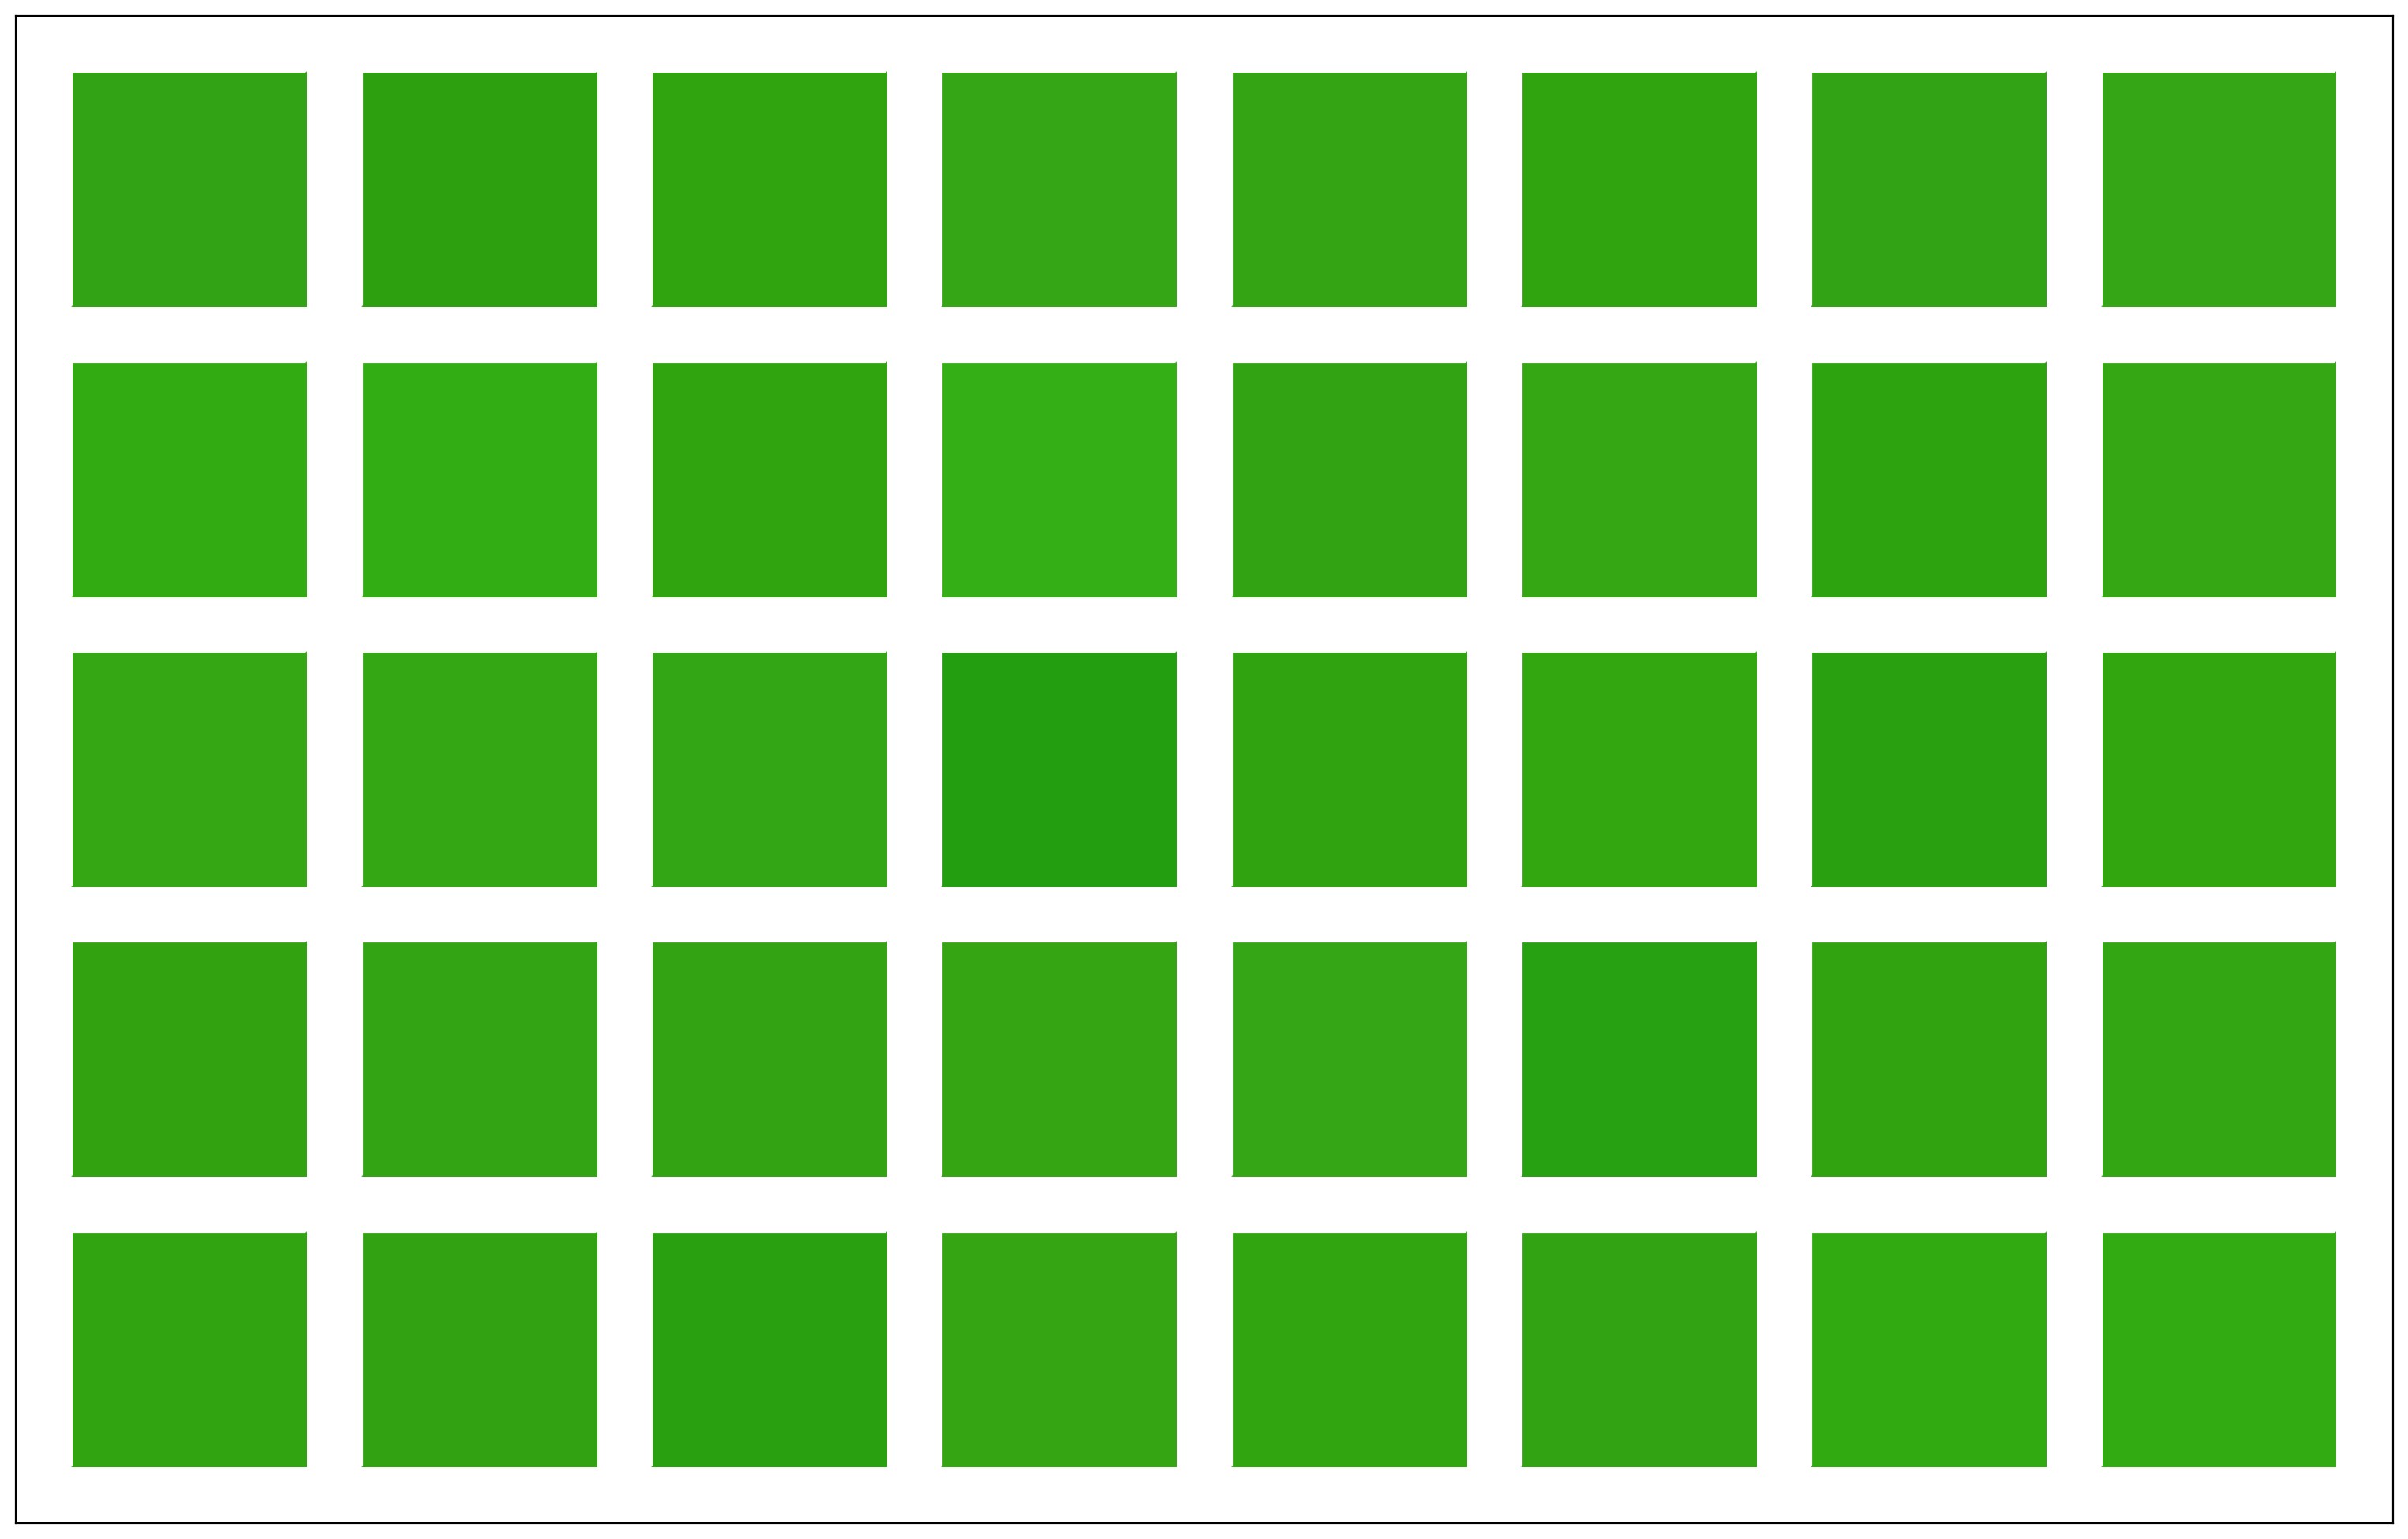

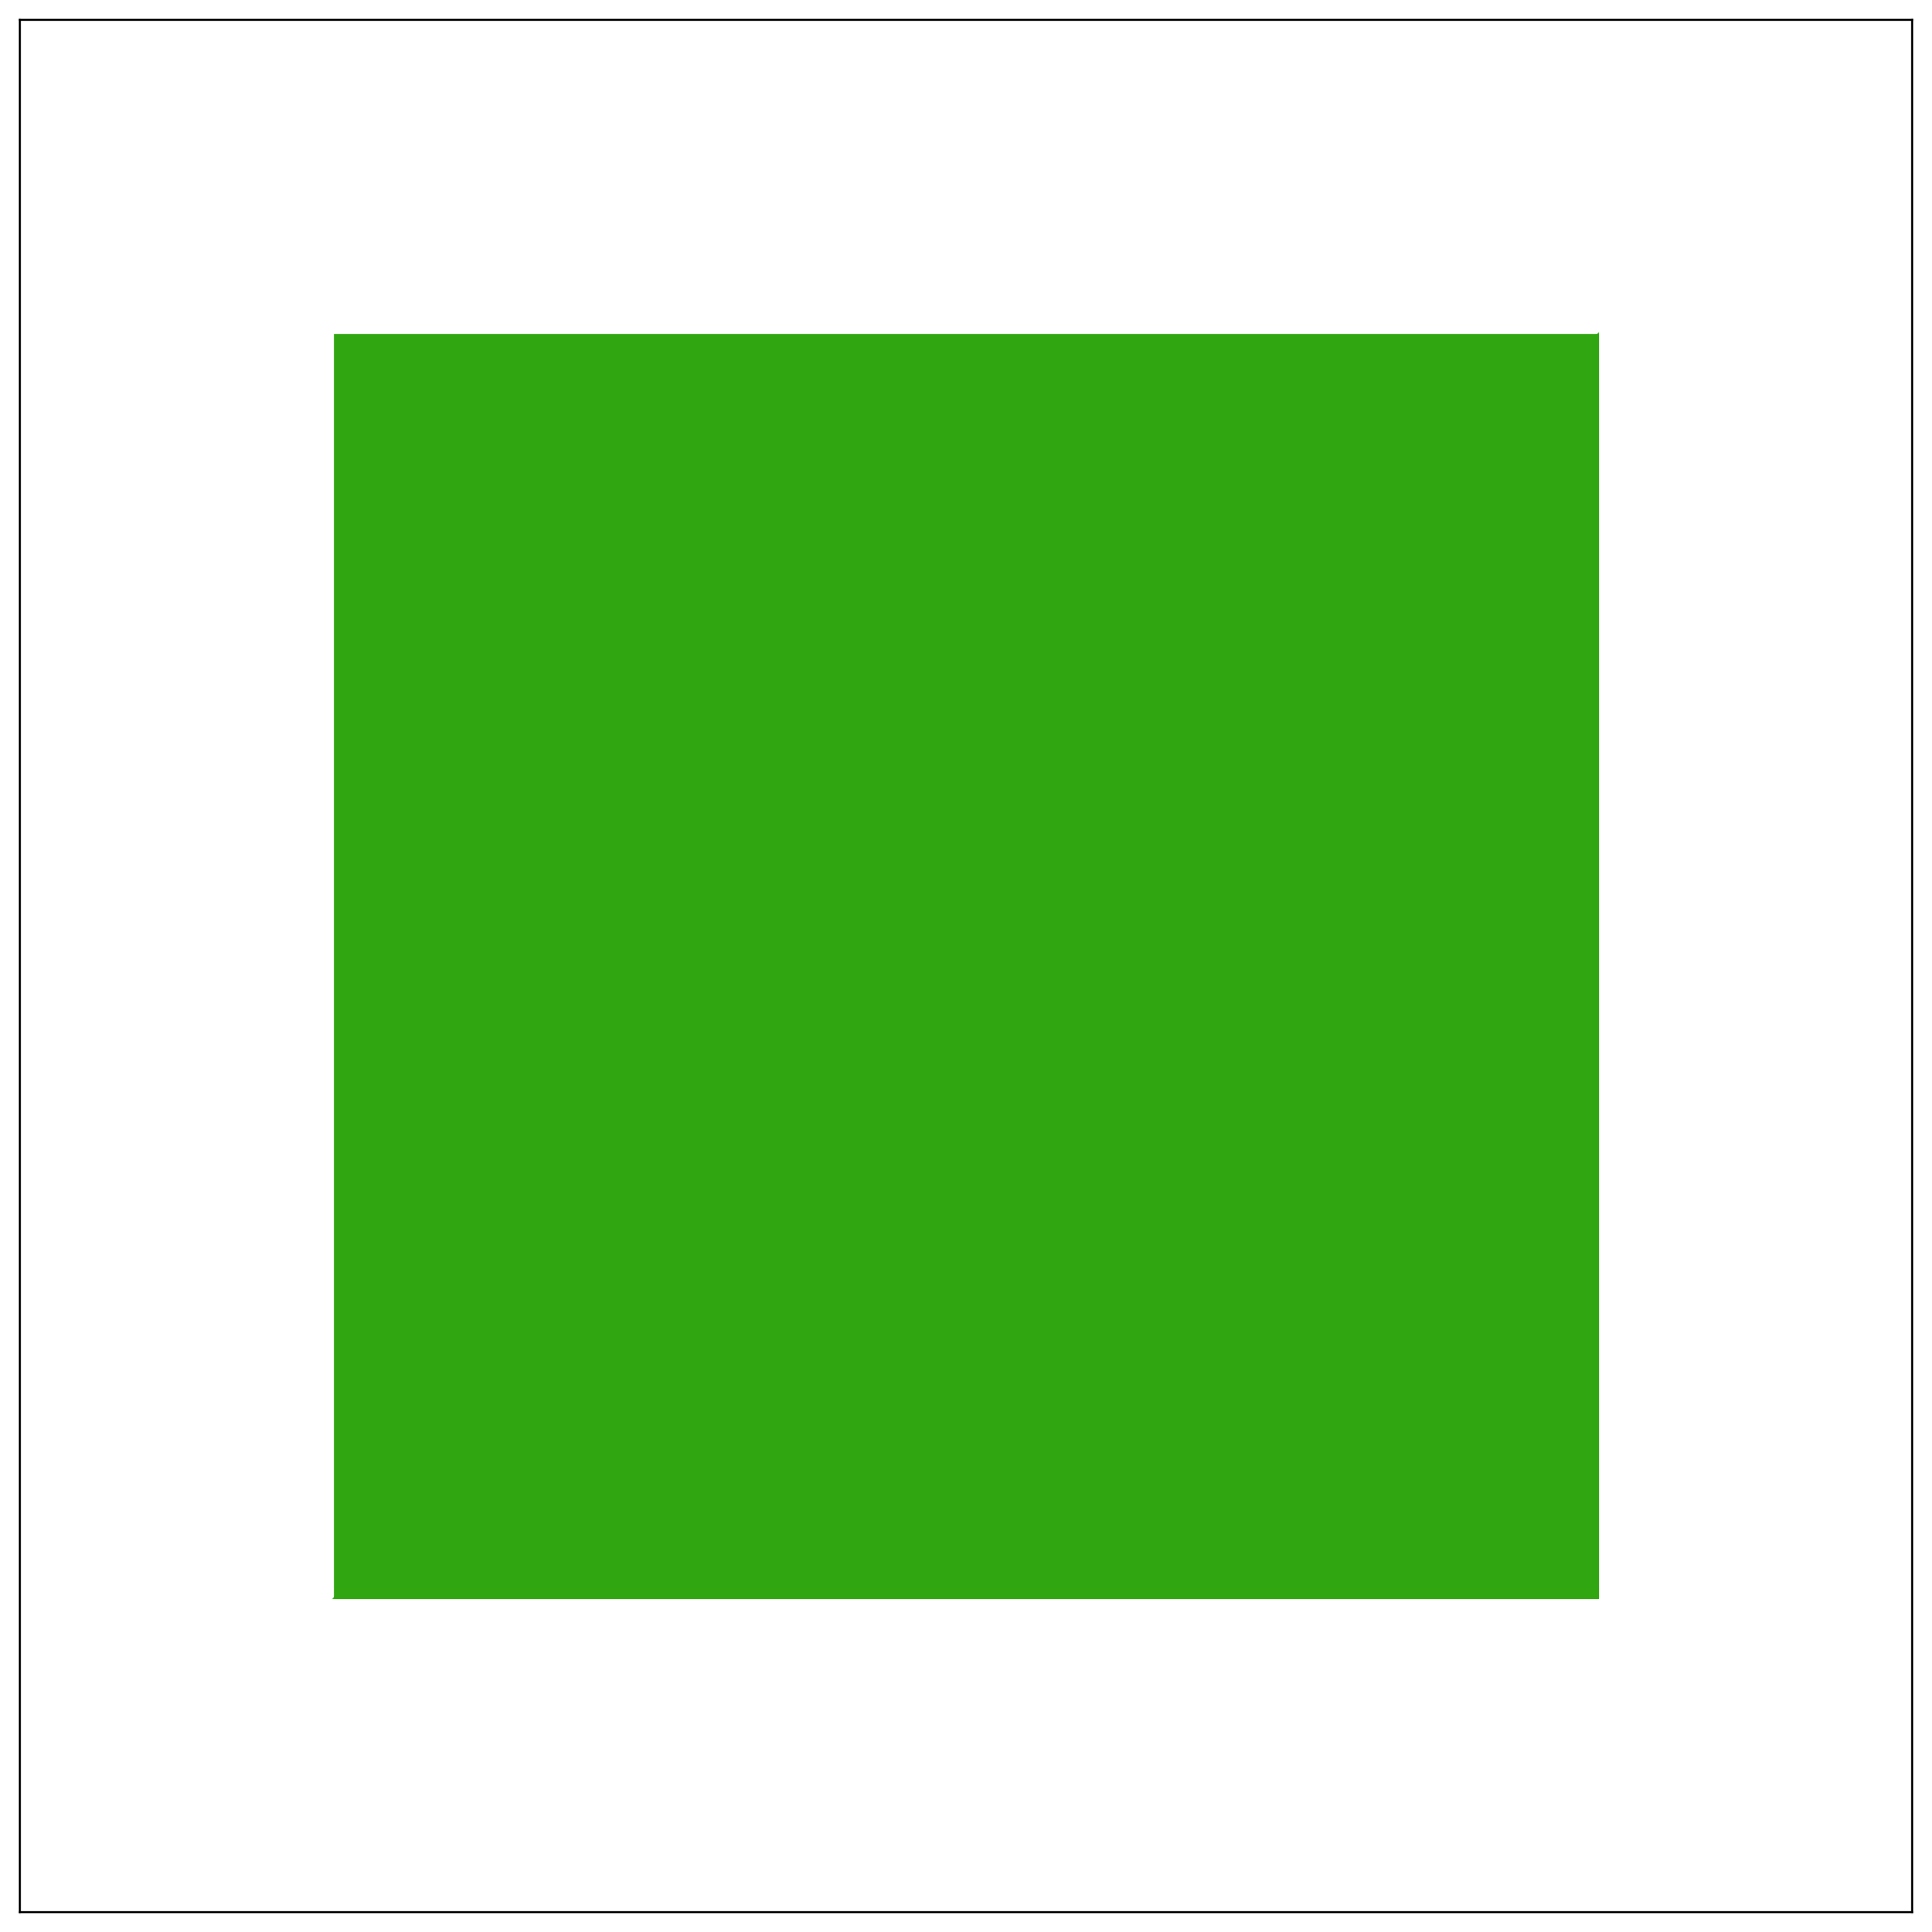

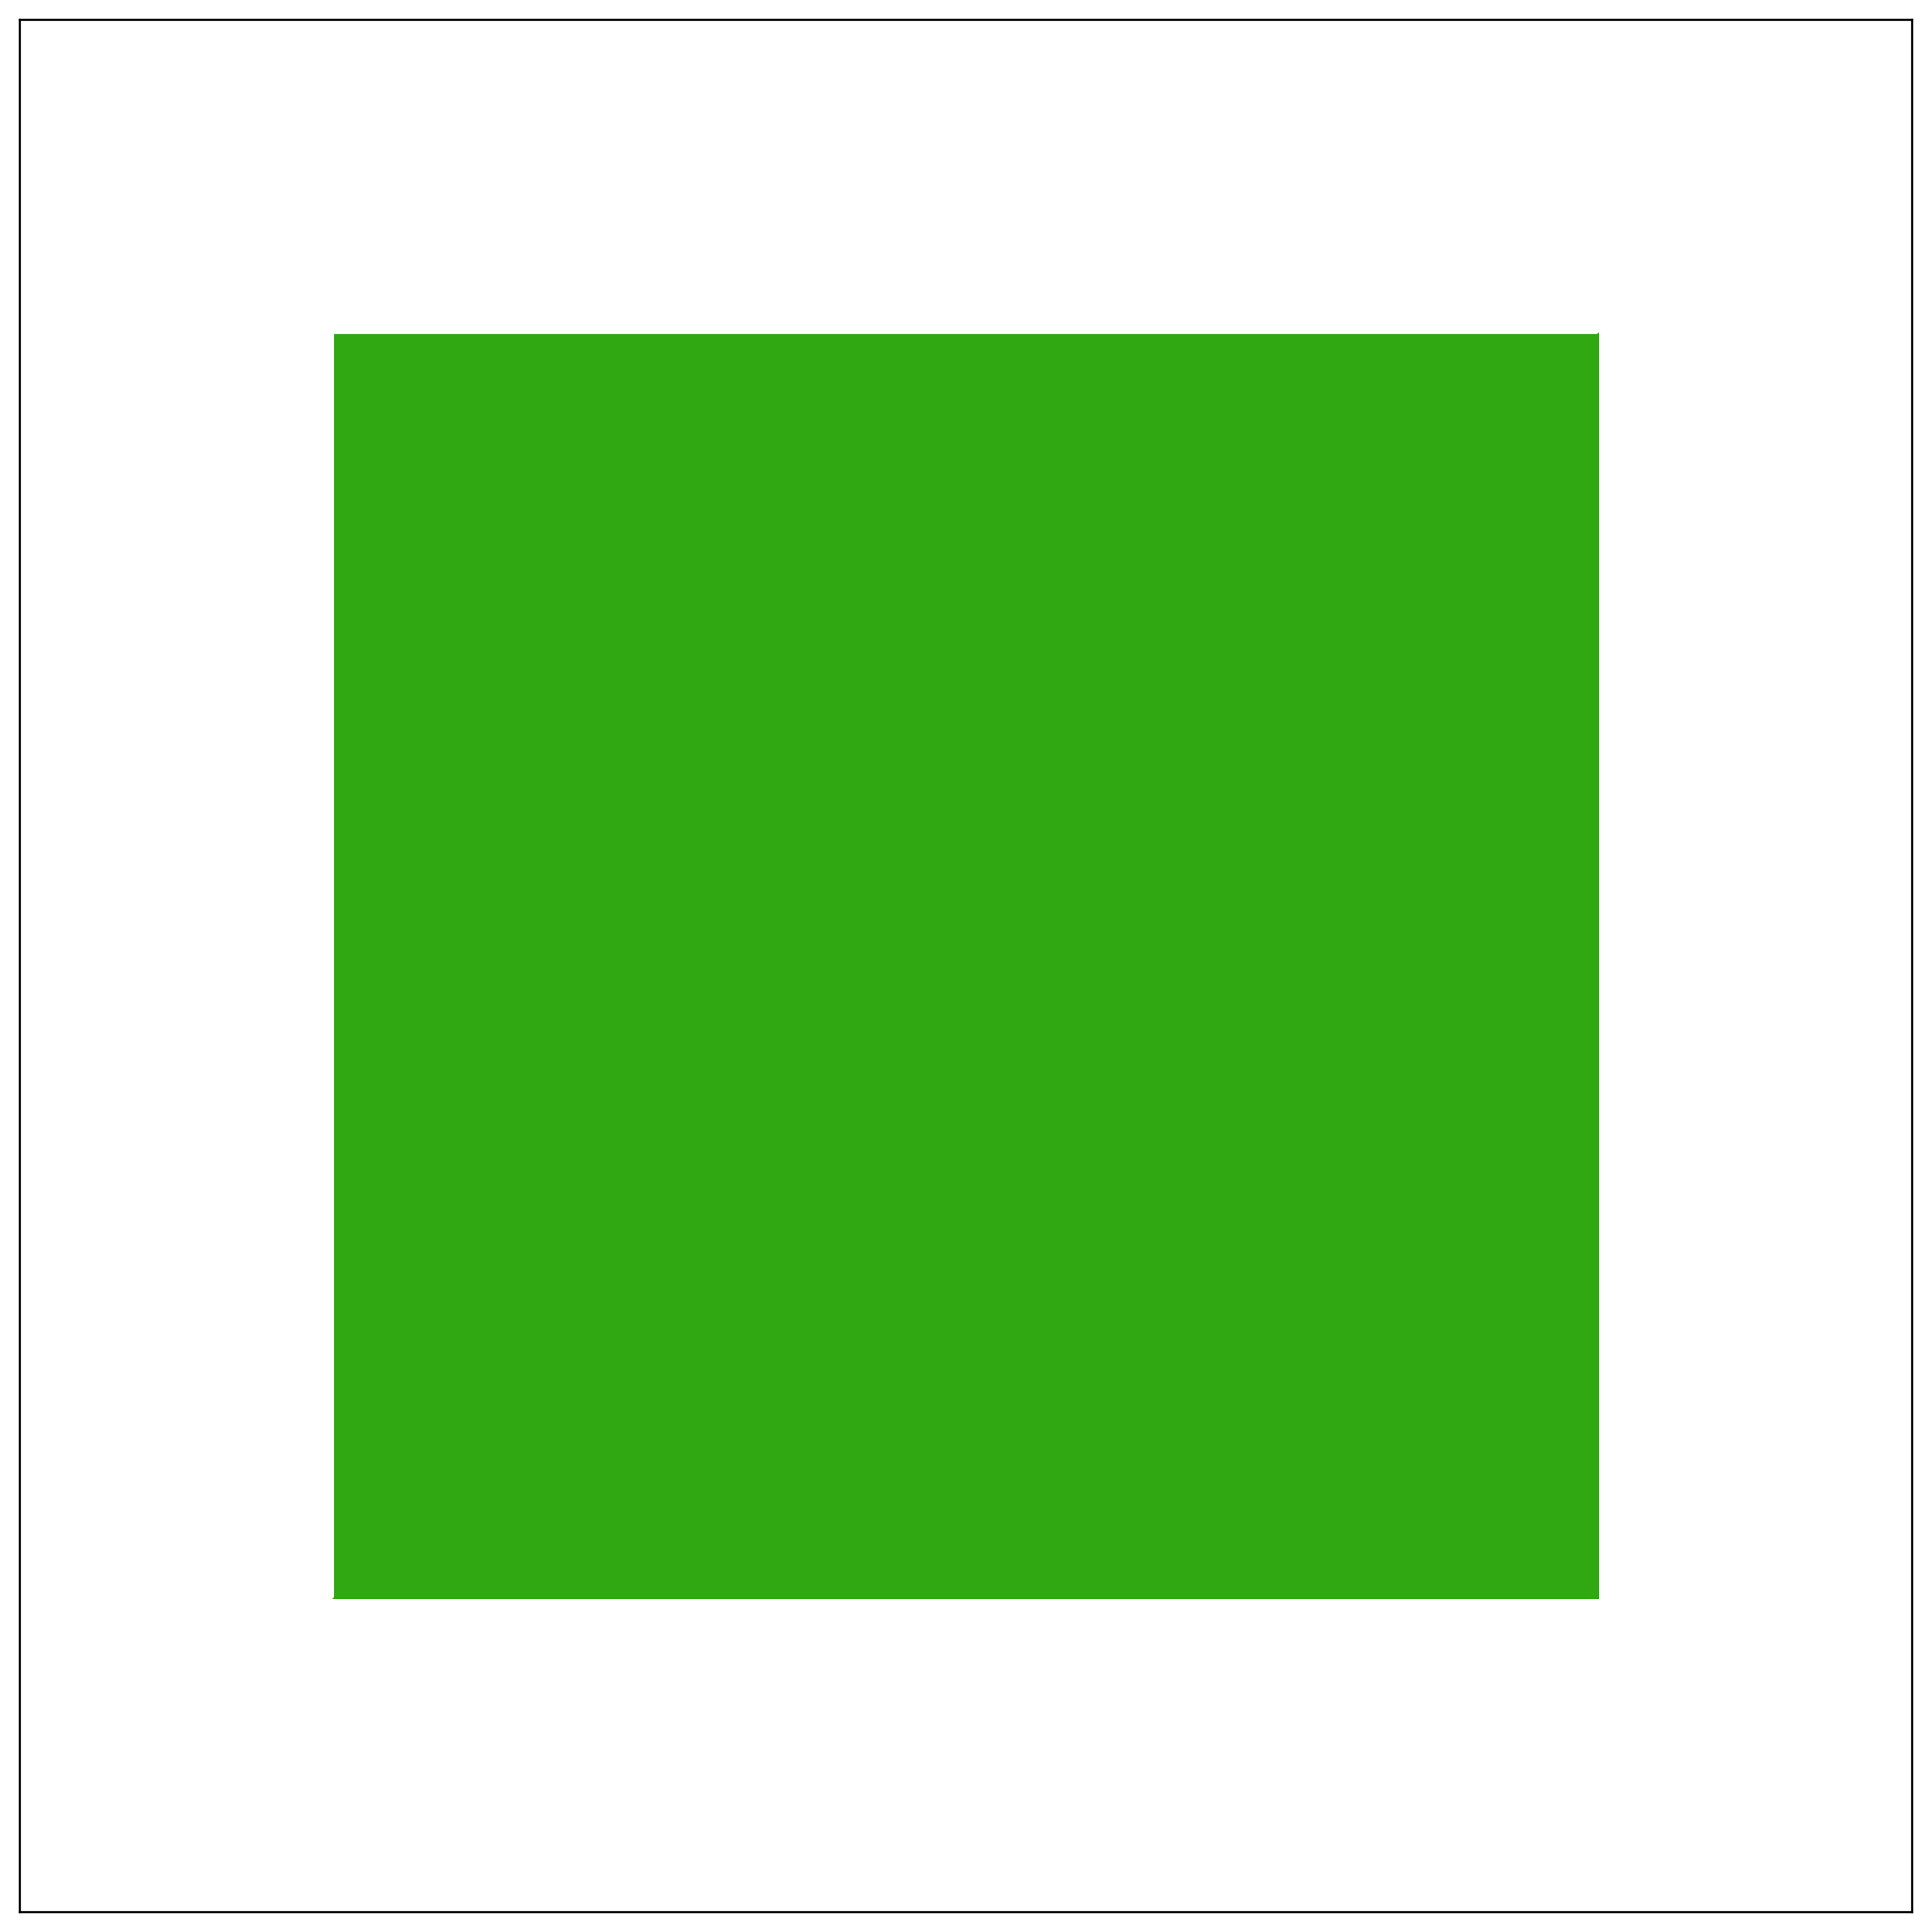

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa6b84673d0>)

In [27]:
# plot 100 CIE and compare


plot_multi_colour_swatches(RGB_pred_vae[np.random.randint(1000, size=40),:], width = 4, spacing=1, height = 4, columns=8)

plot_multi_colour_swatches(RGB_pred_gan[np.random.randint(1000, size=40),:], width = 4, spacing=1, height = 4, columns=8)

plot_multi_colour_swatches(RGB_original[T,:], width = 4, spacing=1, height = 4)

plot_multi_colour_swatches(RGB_pred_tandem[T,:], width = 4, spacing=1, height = 4)